# Introduction

Due to issues rate limiting issues with the DuckDuckGo API in the Kaggle notebook 'Is it a bird?  Creating a model with your own data', this notebook recreates the bird vs forest image classifier using the FastAI library.  The dataset was manually downloaded and organided into bird and forest folders to bypass API limitations, allowing us to focus on model training and evaluation.

## Key Objectives

The key objectives of this notebook are:

1. Organise and prepare the dataset
2. Create and train a convolutional neural network (CNN) to distinguish birds from forests
3. Evaluate the model
4. Establish a reproducible workflow

This notebook will also contain useful notes on the process.  I hope this notebook helps other students to also learn from this fantastic course!

### Lets get started!

#### Data Preparation

The manually downloaded JPEG files are contained within the folders 'birds' and 'forests' within the 'data' folder.  The first activity to be completed is to examine some sample images, by display one random bird and one random forest image from our local dataset.

✅ This code will now:

- Pick one random image from each class.
- Display them side by side.

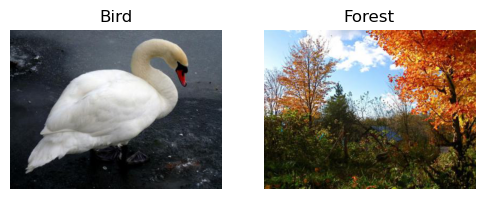

In [31]:
# Import statements
from fastai.vision.all import PILImage   # FastAI's PILImage class for handling images
from pathlib import Path                 # pathlib for path manipulations
import random                            # random for picking random images from folders
import matplotlib.pyplot as plt          # matplotlib to display the images side by side

# Set the path to the dataset
# This is relative to the notebook location
# It points to the folder containing 'bird' and 'forest' subfolders
DATA = Path('FastAI Practical Deep Learning Notebooks/01_is_it_a_bird/data')

# Function to pick a random image from the given class folder ('bird' or 'forest').
# Returns a PILImage - a FastAI image object ready for display or transformation.
def random_image(cls):

    #Lists all files in the class folder with image extensions
    files = [p for p in (DATA/cls).iterdir() if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}]

    # Produces an error if no images are found
    if not files:
        raise RuntimeError(f"No images found in {DATA/cls}")

    # Picks a random file and converts it to a FastAI PILImage
    return PILImage.create(random.choice(files))

# Pick random images
bird_img = random_image('bird')      # Random bird image
forest_img = random_image('forest')  # Random forest image

# Display side by side

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(6,3))

# Display the bird image in the first subplot
axs[0].imshow(bird_img)
axs[0].set_title('Bird')    # Add the title 'bird'
axs[0].axis('off')          # Remove axes for a clean look

# Display the forest image int he second subplot
axs[1].imshow(forest_img)
axs[1].set_title('Forest') # Add the title 'forest'
axs[1].axis('off')         # Remove the axes for a clean look

# Show the figures in the notebook
plt.show()


Next we want to resize the images.  This is needed for the following reasons:

1. Training efficiency
   - Neural networks don't need huge images; smaller images reduce GPU memory usage & training time
2. Uniformity
   - Having images of a similar size makes it easier for FastAI's DataLoaders and transforms to handle batches

✅ What this code does
- Loops over each class (bird and forest).
- Resizes every image in that folder so the largest dimension is at most 400 pixels.
     E.g., if an image is 800x600, it will be resized to 400x300.
- Saves the resized images back to the same folder (dest=DATA/cls).

In [32]:
# Import statements

from fastai.vision.all import resize_images   # Import FastAI utility for resizing images

# Sets the path for the dataset
# This points to the folder containing 'bird' and 'forest' subfolders
DATA = Path('FastAI Practical Deep Learning Notebooks/01_is_it_a_bird/data')

# Resize all images in both folders to max 400 pixels
for cls in ['bird', 'forest']:
    resize_images(
        DATA/cls,        # The folder path for this class
        max_size=400,    # Resizes the longest edge to 400 pixels
        dest=DATA/cls    # Overwrites the images in-place
    )


Next we want to remove failed images.  This is an important part of dataset preparation because:

1. Data Quality
   - Ensures the dataset is free of broken images, which would cause errors during training.
   - Prevents the model from being trained on non-image or corrupted data, leading to a more robust and accurate model.
2. Efficiency
   - Cleans the dataset automatically.  No manual inspection to delete corrupted images, thus saving time.
3. Consistency
   - Ensures all images in the dataset are valid and can be loaded without issues.
   - This is critical for ensuring the DataLoader doesn't encounter errors when fetching batches during training

In [33]:
# Import FastAI utilities to verify the images & get all image files
from fastai.vision.all import verify_images, get_image_files

# Sets the path for the dataset
# This points to the folder containing 'bird' and 'forest' subfolders
DATA = Path('FastAI Practical Deep Learning Notebooks/01_is_it_a_bird/data')

# Find all images that are broken or corrupted

# get_image_files(DATA) scans the folder & its subfolders
# Returns a list of all image files with typical extensions (.jpg, .png, .jpeg)
failed = verify_images(get_image_files(DATA))

# Remove the bad images
# failed.ap(Path.unlink) removes each file in the 'failed' list for the disk
# Path.unlink() deletes the file
failed.map(Path.unlink)

# Reports how many images were deleted
# len(failed) returns the number of corrupt images that were found & deleted
print(f"Removed {len(failed)} corrupted images")


Removed 0 corrupted images


### DataBlocks and DataLoaders

What is a DataBlock in FastAI?

A DataBlock is: 

- A high-level abstraction that defines how your data is structured and processed.
- It is a blueprint for creating a dataset: it specifies
    - where the data lives,
    - how to find it,
    - how to label it,
    - how to split it into training and validation sets
    - what preprocessing or augmentation to apply.
- Once a DataBlock is defined, calling .dataloaders() converts this blueprint into a DataLoaders object.

What is a DataLoader in FastAI?

- A DataLoader is the structure that actually feeds data into the model during training.
- It handles:
   - batching
   - shuffling
   - applying transformations
   - efficiently loading images from disk in real time
- This means that as the model iterates over the dataset, it always receives properly preprocessed batches without requiring the user to write any custom data pipeline code.
- DataLoaders also manages separate training & validation sets, ensuring the model is evaluated correctly on unseen data.

 Together DataBlock and DataLoaders provide a clean separation between data definition and data feeding.

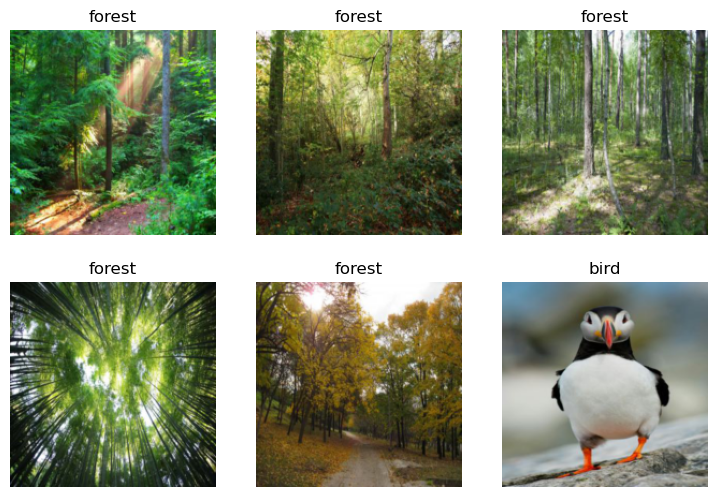

In [37]:
# Import FastAI vision utilities
from fastai.vision.all import *


# Set the path to your dataset
# Using the correct relative path from the current working directory
# This folder contains 'bird' and 'forest' subfolders
DATA = Path('FastAI Practical Deep Learning Notebooks/01_is_it_a_bird/data')

# Create DataLoaders using DataBlock
dls = DataBlock(
    # Inputs: images, Outputs: categories (bird/forest)
    blocks=(ImageBlock, CategoryBlock),
    
    # How to get all image files recursively
    get_items=get_image_files,
    
    # Split dataset into training (80%) and validation (20%) sets
    # Seed ensures reproducibility
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    
    # How to get labels: use the parent folder name
    get_y=parent_label,
    
    # Resize each image to 192x192 pixels
    # 'squish' stretches/squashes to fit exact size
    item_tfms=[Resize(192, method='squish')]
).dataloaders(DATA, bs=32)  # Batch size of 32

# Show a small batch of images
dls.show_batch(max_n=6)



## Create & Train the Model

In FastAI, a Learner is an object that wraps your model, data, loss function, optimiser and metrics into a single interface.  In the cell below vision_learner is used, which is a convenient function for computer vision tasks.

resnet18 is a convolutional neural network that is pre-trained on ImageNet, a large dataset of image.  Using a pre-trained model allows transfer learning where the networks, learned features are adapted to the specific task e.g. bird vs forest, rather than learning from scratch.

In [42]:
from fastai.vision.all import vision_learner, resnet18, error_rate

# Create a Learner object using the DataLoaders and a pre-trained ResNet18
learn = vision_learner(
    dls,        # dls is the DataLoaders object created earlier.  It feeds batches of images & labels to the model during training
    resnet18,   # ResNet-18 is a convolutional neural network that is pre-trained on ImageNet
    metrics=error_rate  # tells FastAI to report the error rate on both training & validation sets during training
)

# Fine-tune the model for 3 epochs
# fine_tune is the FastAI method that first trains only the newly added classifcation head for one epoch and then unfreezes the whole model to fine tune the pre trained layers
learn.fine_tune(3)


epoch,train_loss,valid_loss,error_rate,time
0,1.327102,2.009382,0.500000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,1.555311,1.651941,0.500000,00:00
1,1.300271,0.908724,0.416667,00:00
2,0.991137,0.469717,0.250000,00:01


### Interpreting the Table

| Column       | Meaning                                                                 |
| ------------ | ----------------------------------------------------------------------- |
| `epoch`      | Which epoch of training is being reported (0-based index).              |
| `train_loss` | The loss on the training set — lower is better.                         |
| `valid_loss` | The loss on the validation set — lower indicates better generalization. |
| `error_rate` | The proportion of predictions that were wrong (1 = 100%, 0 = 0%).       |
| `time`       | How long that epoch took to run.                                        |


Observations from your output

Epoch 0
train_loss = 1.327, valid_loss = 2.009, error_rate = 0.5


The model starts fairly untrained on your dataset; 50% of predictions are wrong.

Epoch 1
train_loss = 1.300, valid_loss = 0.909, error_rate = 0.417

The model is learning quickly — validation error drops, indicating it’s starting to recognize patterns.

Epoch 2

train_loss = 0.991, valid_loss = 0.470, error_rate = 0.25
Significant improvement; the model now gets 75% of validation images correct.

✅ Key takeaways

- The model is learning from your images — the decreasing valid_loss and error_rate show improved performance.
- Fine-tuning a pre-trained ResNet18 is effective even with a small dataset.
- If you train longer or add more images, the accuracy is likely to improve further.
- You can now use this trained Learner to make predictions on new images or a batch.


## Inference on a Single Image

The next cell is doing inference on a single image using our trained model.  This is important because:

- This is how you use the trained model for real predictions.
- It shows both the predicted label and the confidence, which is helpful for understanding the model's certainty.

You can swap out preview17.jpeg with other images, even one the model hasn't seen to test its generalisation.

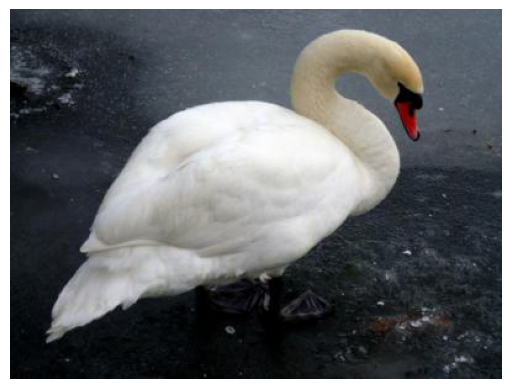

Predicted class: bird
Probability it's a bird: 1.0000


In [44]:
from fastai.vision.all import PILImage
import matplotlib.pyplot as plt

# Pick an image for prediction
# Replace 'preview17.jpg' with any image from your dataset or new images
img_path = DATA/'bird'/'preview17.jpg'

# Load the image in PIL format
img = PILImage.create(img_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Make a prediction
pred_label, _, pred_probs = learn.predict(img)

# Show the predicted class and probability
print(f"Predicted class: {pred_label}")
print(f"Probability it's a bird: {pred_probs[0]:.4f}")
